In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import random
import numpy as np
from PIL import Image
import pandas as pd
import os 
import matplotlib.pyplot as plt
import math
import random
import torch.nn.functional as F

In [2]:
words=open('names.txt').read().splitlines()
chars=sorted(list(set(''.join(words))))
s_to_i={s:i+1 for i,s in enumerate(chars) }
s_to_i['.']=0
i_to_s={i:s for s,i in s_to_i.items()}
vocab_size=len(i_to_s)
s_to_i

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 '.': 0}

In [3]:
def build_dataset(words):
    context_length=8
    x,y=[],[]
    for w in words:
        # print(w)
        context=[0]*context_length
        for ch in w+'.':
            idx=s_to_i[ch]
            x.append(context)
            y.append(idx)
            # print(''.join(i_to_s[i] for i in context),'--->',i_to_s[idx])
            context=context[1:]+[idx]
    x=torch.tensor(x)
    y=torch.tensor(y)
    print(x.shape,y.shape)
    return x,y


random.seed(42)
random.shuffle(words)
n1=int(0.8*len(words))
n2=int(0.9*len(words))

x_train,y_train=build_dataset(words[:n1])
x_val,y_val=build_dataset(words[n1:n2])
x_test,y_test=build_dataset(words[n2:])



torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [4]:
for x,y in zip(x_train[:20],y_train[:20]):
    print(''.join(i_to_s[idx.item()]for idx in x),'-->',i_to_s[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [5]:
class Linear:
    def __init__(self,fan_in,fan_out,bias=True):
        self.weights=torch.randn((fan_in,fan_out))/(fan_in**0.5)
        self.bias=torch.zeros(fan_out) if bias else None 
        
    def __call__(self,x):
        self.out=x @ self.weights 
        if self.bias is not None:
            self.out+=self.bias
        return  self.out
        
    def parameters(self):
        return [self.weights]+ ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self,dim,eps=1e-5,momentum=0.1):
        self.eps=eps
        self.momentum=momentum
        self.training=True
        # paramameters for scale and shift
        self.gamma=torch.ones(dim)
        self.beta=torch.zeros(dim)
        # buffers
        self.running_mean=torch.zeros(dim)
        self.running_var=torch.ones(dim)

    def __call__(self,x):
        if self.training:
            xmean=x.mean(0,keepdim=True)
            xvar=x.var(0,keepdim=True)
        else:
            xmean=self.running_mean
            xvar=self.running_var
        xnorm=(x-xmean)/torch.sqrt(xvar+self.eps)
        self.out=self.gamma*xnorm+self.beta
        # update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean=(1-self.momentum)*self.running_mean + self.momentum*xmean
                self.running_var=(1-self.momentum)*self.running_var+self.momentum*xvar
                
        return self.out
        
    def parameters(self):
        return [self.gamma,self.beta]
        

class Tanh:
    def __call__(self,x):
        self.out=torch.tanh(x)
        return self.out
    def parameters(self):
        return []
            
        
class Embeddings:
    def __init__(self,num_embeds,emb_dim):
        self.emb_weights=torch.randn((num_embeds,emb_dim))

    def __call__(self,idx):
        self.out=self.emb_weights[idx]
        return self.out

    def parameters(self):
        return [self.emb_weights]

class Flatten:
    def __call__(self,x):
        self.out=x.view(x.shape[0],-1)
        return self.out

    def parameters(self):
        return []

class Sequential:
    def __init__(self,layers):
        self.layers=layers

    def __call__(self,x):
        for layer in self.layers:
            x=layer(x)
        self.out=x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        
        

In [6]:
torch.manual_seed(42);

In [7]:
# hyperparameters 
batch_size=32
emb_space=10
context_length=8
# x_view=x_train.shape[1]*emb_space
h_units=200
# C=torch.randn((vocab_size,emb_space))
lossi=[]
steps=[]
lri=[]
lrex=[]
ud=[]

model=Sequential([Embeddings(vocab_size,emb_space),Flatten(),
    Linear(emb_space*context_length,h_units,bias=False),BatchNorm1d(h_units),Tanh(),
    Linear(h_units,vocab_size)
])

with torch.no_grad():
    model.layers[-1].weights*=0.1
    # layers[-1].gamma*=0.1  # making last layer less confident 
    # for layer in layers[:-1]:
    #     if isinstance(layer,Linear):
    #         layer.weights*=5/3

parameters= model.parameters()
for p in parameters:
    p.requires_grad=True

print(sum(p.nelement() for p in parameters))

22097


In [8]:
max_steps=200000
for i in range(max_steps):
    #minibatch construct
    ix=torch.randint(0,x_train.shape[0],(batch_size,)) 
    #foward pass
    x=x_train[ix]
    logits=model(x)
    loss=F.cross_entropy(logits,y_train[ix])
    #backward pass
    # for layer in layers:
    #     layer.out.retain_grad()
    for p in parameters:
        p.grad=None
    loss.backward()
    
    lr=0.1 if i<150000 else 0.01
        
    for p in parameters:
            p.data+=-lr*p.grad

     # track stats
    if i%10000==0:
        print(f'{i:7d}/{max_steps:7d} : {loss.item():.4f}')
    steps.append(i)
    lossi.append(loss.log10().item())

    with torch.no_grad():
        ud.append([(lr*p.grad.std()/ p.data.std()).log10().item() for p in parameters])
    # break
    # if i>9998:
    #     break

      0/ 200000 : 3.2847
  10000/ 200000 : 2.0647
  20000/ 200000 : 1.9722
  30000/ 200000 : 2.0948
  40000/ 200000 : 1.9738
  50000/ 200000 : 2.1287
  60000/ 200000 : 2.3574
  70000/ 200000 : 1.9131
  80000/ 200000 : 2.0735
  90000/ 200000 : 2.0968
 100000/ 200000 : 1.4963
 110000/ 200000 : 2.1294
 120000/ 200000 : 2.2324
 130000/ 200000 : 2.2071
 140000/ 200000 : 2.2326
 150000/ 200000 : 1.8908
 160000/ 200000 : 1.6867
 170000/ 200000 : 2.0968
 180000/ 200000 : 1.7824
 190000/ 200000 : 1.9151


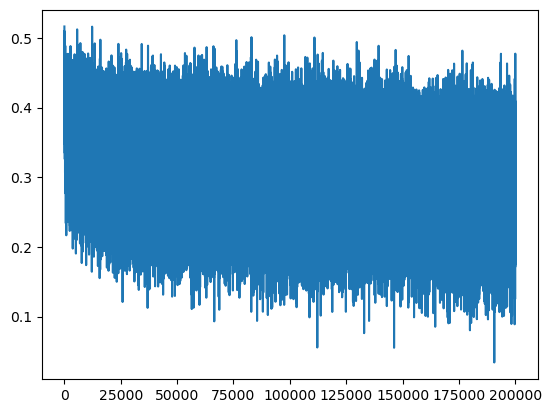

In [9]:
plt.plot(lossi)

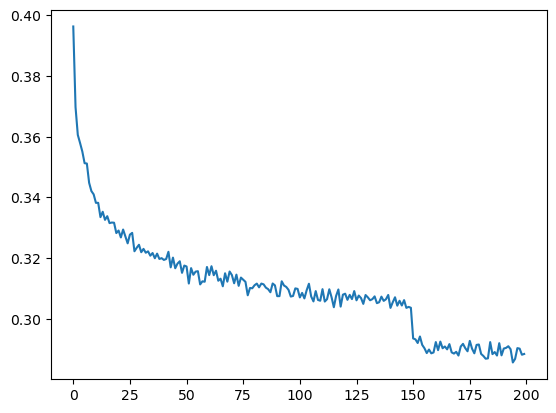

In [10]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1));

In [11]:
for layer in model.layers:
    layer.training=False


In [12]:
@torch.no_grad()
def split_loss(split):
    x,y={
        'train':(x_train,y_train),
        'val':(x_val,y_val),
        'test':(x_test,y_test)
        }[split]
    
    logits=model(x)
    loss=F.cross_entropy(logits,y)
    
    print(split,loss.item())

split_loss('train')
split_loss('val')

train 1.9163438081741333
val 2.034248113632202


In [13]:
# # sampling from the moodel 
# g=torch.Generator().manual_seed(2147483647)
for i in range(20):
    out=[]
    context=[0]*context_length
    while True:
        # emb=C[torch.tensor([context])] #(1,conntext_length,d)
        x=torch.tensor([context])
        logits=model(x)
        probs=F.softmax(logits,dim=1)
        idx=torch.multinomial(probs,num_samples=1).item()
        context=context[1:]+[idx]
        out.append(idx)
        if idx==0:
            break
    print(''.join(i_to_s[i] for i in out))

yeverii.
kya.
kylek.
tisire.
porbyn.
abib.
merighlynn.
loriel.
jiildy.
davryah.
brone.
thorder.
nyleah.
miromell.
oluwase.
josusas.
ramia.
herlio.
delina.
maclai.
